# Motor Temperature Predictions

In this notebook I will construct a Neural Network that predicts the motor temperature of an electric using information from sensors in and around the engine. This data can be found on [kaggle](https://www.kaggle.com/wkirgsn/electric-motor-temperature)

In [1]:
import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Preprocessing

In [2]:
# Import pandas and numpy to work with data
import numpy as np
import pandas as pd

# Read data usign Pandas
data = pd.read_csv('pmsm_temperature_data.csv')
# Check data types
data.dtypes

ambient           float64
coolant           float64
u_d               float64
u_q               float64
motor_speed       float64
torque            float64
i_d               float64
i_q               float64
pm                float64
stator_yoke       float64
stator_tooth      float64
stator_winding    float64
profile_id          int64
dtype: object

In [3]:
# Use pandas .corr function to check the correlations between features to find which ones make good predictors
data.corr()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
ambient,1.000000,0.434435,0.194754,0.087430,0.078283,-0.262264,0.005605,-0.260562,0.501496,0.451616,0.396742,0.301883,0.384565
coolant,0.434435,1.000000,0.178708,0.027851,-0.033332,-0.189617,0.108489,-0.186060,0.430548,0.874037,0.689003,0.509298,0.499669
u_d,0.194754,0.178708,1.000000,-0.027472,-0.233828,-0.821325,0.358517,-0.796586,-0.082564,0.041428,-0.066256,-0.150714,0.300771
u_q,0.087430,0.027851,-0.027472,1.000000,0.716897,-0.037262,-0.181855,-0.026348,0.101236,0.106186,0.149017,0.125445,-0.122260
motor_speed,0.078283,-0.033332,-0.233828,0.716897,1.000000,0.024517,-0.722914,0.006323,0.332419,0.182564,0.333909,0.393154,-0.166225
torque,-0.262264,-0.189617,-0.821325,-0.037262,0.024517,1.000000,-0.239059,0.996560,-0.072905,-0.092207,-0.011055,0.080981,-0.257446
i_d,0.005605,0.108489,0.358517,-0.181855,-0.722914,-0.239059,1.000000,-0.204230,-0.299227,-0.179903,-0.387712,-0.539924,0.142368
i_q,-0.260562,-0.186060,-0.796586,-0.026348,0.006323,0.996560,-0.204230,1.000000,-0.086486,-0.098753,-0.025191,0.060949,-0.256127
pm,0.501496,0.430548,-0.082564,0.101236,0.332419,-0.072905,-0.299227,-0.086486,1.000000,0.695014,0.768352,0.729561,0.156735
stator_yoke,0.451616,0.874037,0.041428,0.106186,0.182564,-0.092207,-0.179903,-0.098753,0.695014,1.000000,0.949898,0.845144,0.398021


In [4]:
# Select x and y variables based on the previous step

x=data[['coolant', 'stator_tooth', 'stator_winding']]
y=data['stator_yoke']

In [5]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [6]:
# Check feature statistics to see if they need to be normalized

train_stats = x_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
coolant,798456.0,0.003897,1.001926,-1.367800,-1.037831,-0.178616,0.628618,2.451653
stator_tooth,798456.0,-0.002673,0.999466,-2.066143,-0.761951,0.004557,0.771817,2.326668
stator_winding,798456.0,-0.004285,0.998148,-2.019973,-0.725642,0.006146,0.724973,2.653781


In [7]:
# Normalize data

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train = norm(x_train)
normed_test = norm(x_test)

### Model

In [21]:
# Import Keras 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras import layers

# Build sequential model
model = Sequential()
model.add(Dense(128, input_dim=3, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

# choose optimizer and learning rate
opt = optimizers.nadam(lr=.00001)

# Compile model
model.compile(loss='mse',
              optimizer=opt,
              metrics=['mae'])


In [22]:
# Fit model to normalized data
model.fit(normed_train, y_train,
          epochs=5,
          batch_size=128)

Epoch 1/5
798456/798456 [==============================] - 32s 40us/step - loss: 0.0759 - mean_absolute_error: 0.1558
Epoch 2/5
798456/798456 [==============================] - 31s 39us/step - loss: 0.0093 - mean_absolute_error: 0.0715
Epoch 3/5
798456/798456 [==============================] - 31s 39us/step - loss: 0.0066 - mean_absolute_error: 0.0613
Epoch 4/5
798456/798456 [==============================] - 31s 39us/step - loss: 0.0057 - mean_absolute_error: 0.0571
Epoch 5/5
798456/798456 [==============================] - 31s 39us/step - loss: 0.0052 - mean_absolute_error: 0.0545


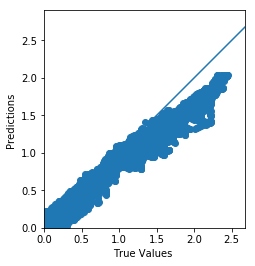

In [23]:
# Import matplot lib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# use model to make predictions on testing set
test_predictions = model.predict(x_test).flatten()

# Plot fidnings
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

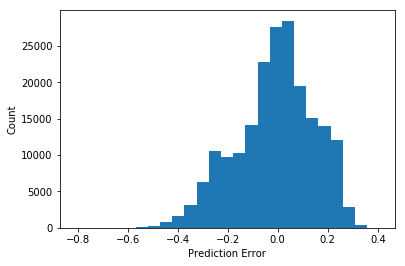

In [24]:
# Check error distribution
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [25]:
# Save model
from keras.models import load_model

model.save('Motor_Temperature.h5')  

Over all this model worked fairly well to predict the motor temperature. It took a couple of different tries to pick the x and y variables as I originally was trying to predict 'pm' using the stator variables but it did not work very well. 